# Análise de oscilações do preço do Ibovespa sob um olhar estatístico

## 1. Introdução

O Ibovespa é o indicador mais importante do desempenho médio das cotações das ações negociadas na B3, sendo formado pelas ações com maior volume negociado nos últimos meses.

É do nosso interesse entender como diferentes fatores podem impactar na cotação desse índice. Nesse arquivo são explorados as seguintes perguntas:

1. Há diferenças nas variações para diferentes dias da semana ou meses?
2. Feriados nos quais a bolsa fica fechada impactam de que forma a cotação?
3. Como definições da SELIC Meta na reunião do COPOM impactam na cotação do Ibovespa no período subsequente?

Para as análises são usados dados de abertura e fechamento extraídos através da biblioteca yahoo finance entre 01/05/1993 e 27/08/2021.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import scipy
from IPython.display import Markdown as md
import warnings
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import plotly.graph_objs as go
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
ticker='^BVSP'
start_date='1990-01-01'
end_date='2021-10-30'
variables=['Open','Close','High','Low']

data_1d=yf.Ticker(ticker).history(interval='1d',start=start_date,end=end_date)[variables]
data_1m=yf.Ticker(ticker).history(interval='1mo',start=start_date,end=end_date)[variables]
start_date=datetime.datetime(2019,9,1)
end_date=datetime.datetime(2021,10,30)


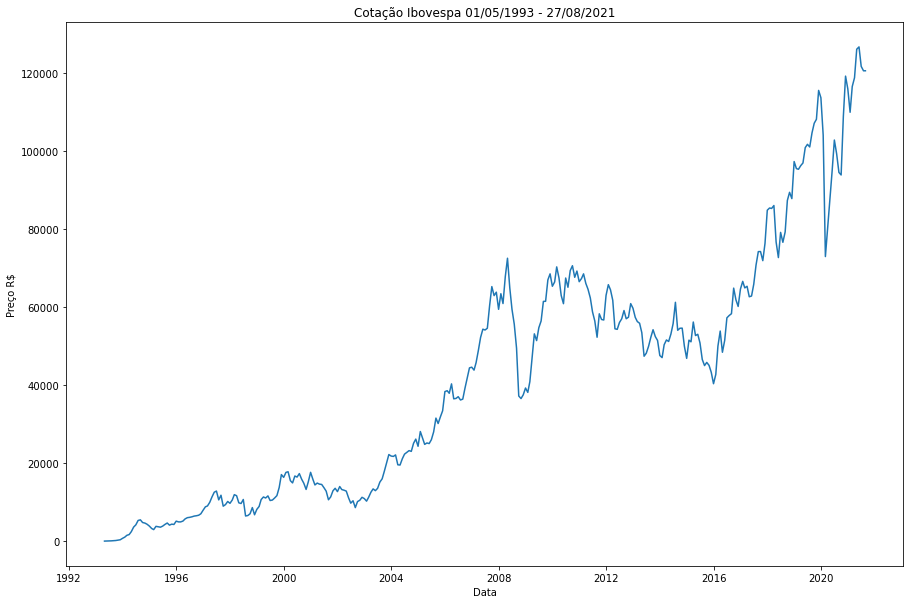

In [3]:
plt.figure(figsize=(15,10))
plt.plot(data_1m['Close'])

plt.xlabel("Data")
plt.ylabel("Preço R$")

plt.title("Cotação Ibovespa 01/05/1993 - 27/08/2021")
a=1

In [4]:
data_1d

,Open,Close,High,Low
Date,,,,
1993-04-27,24.799999,24.500000,25.400000,24.500000
1993-04-28,24.500000,24.299999,24.600000,23.700001
1993-04-29,24.299999,23.700001,24.799999,23.700001
1993-04-30,23.700001,24.100000,24.200001,23.700001
1993-05-03,24.100000,24.100000,24.400000,23.799999
...,...,...,...,...
2021-08-23,118053.000000,117472.000000,118445.000000,117062.000000
2021-08-24,117474.000000,120211.000000,120463.000000,117474.000000
2021-08-25,120210.000000,120818.000000,120818.000000,119226.000000


## 2. Analisando variações diárias

### 2.1 Dia da semana

Para cada dia em que se obteve uma cotação, foi calculada a seguinte medida:

Aumento percentual em relação ao preço de fechamento anterior: ((cotação fechamento dia) - (cotação fechamento dia anterior))/(cotação fechamento dia anterior)

Com essa variação, foram calculadas a média, mediana e desvio padrão para cada dia da semana, assim como a porcentagem de dias positivos, o número de dias com grandes ganhos e perdas.
Um resumo das métricas de cada dia é exibido abaixo.

In [5]:
data_1d['weekday']=data_1d.index.map(lambda x:x.weekday)
data_1d['day']=data_1d.index.map(lambda x:x.day)
data_1d['month']=data_1d.index.map(lambda x:x.month)
data_1d['days_in_month']=data_1d.index.map(lambda x:x.days_in_month)

data_1d['Previous_close']=data_1d['Close'].shift(1)

data_1d['Open_last_week']=data_1d['Open'].shift(5)

data_1d['%Increase_since_last_close']=data_1d.apply(lambda x:100*(x['Close']-x['Previous_close'])/x['Previous_close'],axis=1)
data_1d['%Increase_since_last_close_previous_day']=data_1d['%Increase_since_last_close'].shift(1)

data_1d['%Increase_previous5days']=data_1d.apply(lambda x:100*(x['Close']-x['Open_last_week'])/x['Open_last_week'],axis=1)

data_1d['Positive_increase']=data_1d['%Increase_since_last_close']>=0

In [6]:
grouped_data_weekday=data_1d[['%Increase_since_last_close','weekday']].groupby(['weekday']).agg({'%Increase_since_last_close':[np.median,np.mean,np.std]})['%Increase_since_last_close']
positive_increase=data_1d.groupby(['weekday']).mean()['Positive_increase']
corrections_higher_than_75=data_1d[data_1d['%Increase_since_last_close'].map(lambda x:x>5)].groupby(['weekday']).count()['%Increase_since_last_close']
corrections_lower_than_75=data_1d[data_1d['%Increase_since_last_close'].map(lambda x:x<-5)].groupby(['weekday']).count()['%Increase_since_last_close']

grouped_data_weekday.index=['Segunda','Terça','Quarta','Quinta','Sexta']
grouped_data_weekday['Porcentagem positivo']=positive_increase.values*100
grouped_data_weekday['Número de dias com aumento maior que 5%']=corrections_higher_than_75.values
grouped_data_weekday['Número de dias com diminuição menor que -5%']=corrections_lower_than_75.values

grouped_data_weekday.rename(columns={'median':'Mediana','mean':'Média','std':'Desvio padrão'})

,Mediana,Média,Desvio padrão,Porcentagem positivo,Número de dias com aumento maior que 5%,Número de dias com diminuição menor que -5%
Segunda,0.044611,-0.005945,2.317071,51.397849,29,29
Terça,0.180246,0.248167,2.171425,54.220315,34,10
Quarta,0.122295,0.197393,2.097438,53.234880,27,16
Quinta,0.110293,0.047276,2.331597,52.620244,25,33
Sexta,0.187560,0.244567,2.292173,54.741379,26,13


Da tabela é possível verificar:

1. O dia mais negativo é segunda, que teve uma média e mediana bastante abaixo dos outros dias.
2. As maiores diminuições nas cotações ocorrem segunda e quinta, em que ocorreram 29 e 33 dias com diminuição menor que -5% respectivamente.
3. Quinta é o dia em que mais houveram dias muito negativos, o que é refletido numa média bastante abaixo da mediana (a mediana é menos impactada por esses outliers) 
4. Os dias mais positivos são terça e sexta, validado por diversas métricas: média, mediana, porcentagem de dias positivos e número de dias com aumento maior que 5%.

Na figura abaixo pode-se verificar a distribuição das mudanças percentuais em cada dia (não são mostradas variações maiores que 7.5% e menores que -7.5%).

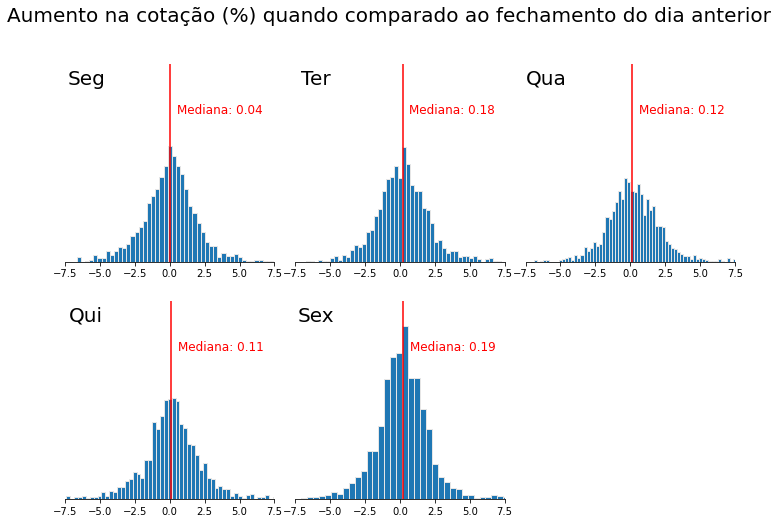

In [7]:

weekday_dict={0:'Seg',1:'Ter',2:'Qua',3:'Qui',4:'Sex'}
fig,axes=plt.subplots(2,3,figsize=(12,8),sharex=False,sharey=True)
data_1d_low_change=data_1d[data_1d['%Increase_since_last_close'].map(lambda x:abs(x)<7.5)]
for i in np.arange(5):
    ax=axes.flatten()[i]
    data_this_month=data_1d[data_1d['weekday']==i]
    ax.hist(data_this_month['%Increase_since_last_close'],bins=100, edgecolor='#E6E6E6')
    ax.annotate('{}'.format(weekday_dict[i]),[-6,180],fontsize=20,ha='center')
    ax.set_xlim([-7.5,7.5])
    median=grouped_data_weekday['median'][i]
    #mean=grouped_data_weekday['mean'][i]

    ax.text(median+0.5,150,'Mediana: {:.2f}'.format(median),color='red',fontsize=12)
    ax.axvline(median,ymin=0,ymax=2,color='red')
    #ax.text(mean+0.5,170,'Mean: {:.2f}'.format(mean),color='green',fontsize=12)
    #ax.axvline(mean,ymin=0,ymax=2,color='green')
i=0
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    if i==5:
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

    i+=1

plt.subplots_adjust(hspace=0.2,wspace=0.1)
plt.xlim(-7.5,7.5)
plt.suptitle('Aumento na cotação (%) quando comparado ao fechamento do dia anterior',fontsize=20)
plt.ylim(0,200)
a=1

In [8]:
series_segunda=data_1d[data_1d['weekday']==0]['%Increase_since_last_close'].dropna().values
series_terca=data_1d[data_1d['weekday']==1]['%Increase_since_last_close'].dropna().values
series_quarta=data_1d[data_1d['weekday']==2]['%Increase_since_last_close'].dropna().values
series_quinta=data_1d[data_1d['weekday']==3]['%Increase_since_last_close'].dropna().values
series_sexta=data_1d[data_1d['weekday']==4]['%Increase_since_last_close'].dropna().values
dict_series={0:series_segunda,1:series_terca,2:series_quarta,3:series_quinta,4:series_sexta}

Por mais que argumentou-se anteriormente que segunda foi o dia mais negativo e sexta o mais positivo, as médias ainda se encontram muito próximas umas das outras. É feito portanto um teste estatístico para se validar se essa diferença é estatisticamente relevante.

Ao se comparar as distribuições usando-se um T-test para as médias dos aumentos percentuais numa segunda e numa sexta, assumindo ainda uma variância igual entre ambas as populações (desvios padrões eram similares), obtém-se um valor de p igual a **0.00415**, o que significa que a hipótese de que ambas as médias são iguais pode ser rejeitada. Em outras palavras, há uma probabilidade de apenas **0.415%** de que as médias de variação percentual dos dois dias seja igual.

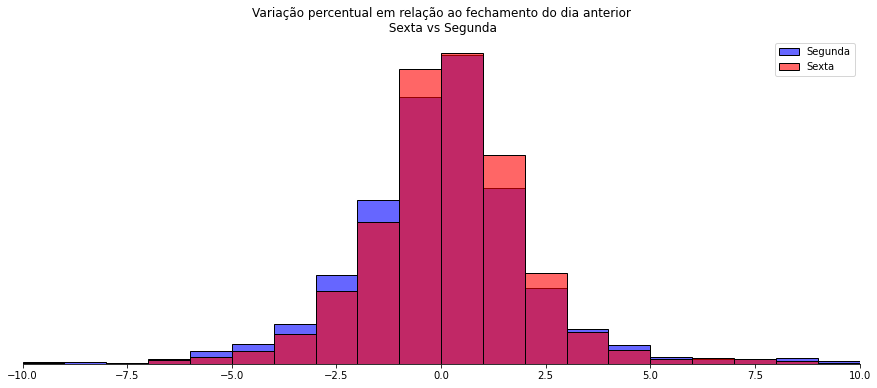

In [9]:
fig,ax=plt.subplots(figsize=(15,6))
sns.histplot(series_segunda,color='blue',label='Segunda',alpha=0.6,binwidth=1,binrange=[-10,10])
sns.histplot(series_sexta,color='red',label='Sexta',alpha=0.6,binwidth=1,binrange=[-10,10])
plt.xlim(-10,10)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('')
plt.title('Variação percentual em relação ao fechamento do dia anterior\n Sexta vs Segunda')
plt.legend()
s,p=scipy.stats.ttest_ind(series_segunda,series_sexta)
md('Ao se comparar as distribuições usando-se um T-test para as médias dos aumentos percentuais numa segunda e numa sexta, assumindo ainda uma variância igual entre ambas as populações (desvios padrões eram similares), obtém-se um valor de p igual a **{:.5f}**, o que significa que a hipótese de que ambas as médias são iguais pode ser rejeitada. Em outras palavras, há uma probabilidade de apenas **{:.3f}%** de que as médias de variação percentual dos dois dias seja igual.'.format(p,100*p))

In [10]:
p_values=[]
for serie1 in dict_series:
    p_value_serie1=[]
    for serie2 in dict_series:
        s,p=stats.ttest_ind(dict_series[serie1],dict_series[serie2])
        p_value_serie1+=[p]
    p_values+=[p_value_serie1]

A mesma metodologia é aplicada a todos os pares de dias da semana, obtendo-se a matriz de p_values abaixo. Considerando-se que um p_value menor que 0.05 seja suficiente para afirmar que há diferença entre os dois dias, percebe-se que segunda e quinta são dias similares entre si. Da mesma forma, terça, quarta e sexta também apresentam comportamento similar, não sendo possível afirmar que há uma diferença entre esses dias.

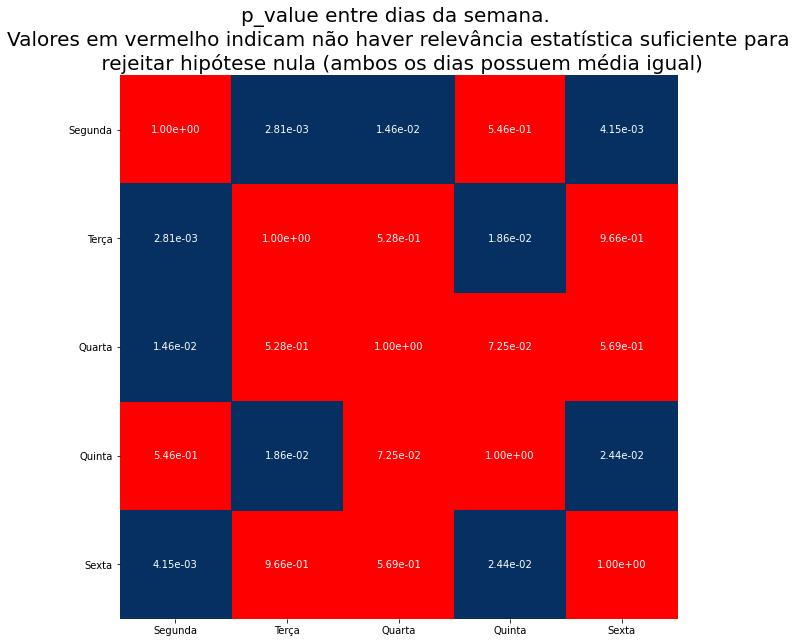

In [11]:
plt.figure(figsize=(10,10))
p_values_df=pd.DataFrame(p_values)
p_values_df.index=['Segunda','Terça','Quarta','Quinta','Sexta']
p_values_df.columns=['Segunda','Terça','Quarta','Quinta','Sexta']
sns.heatmap(p_values_df,mask=p_values_df<0.05,cmap='rainbow_r',vmin=0,vmax=100000,annot=True,fmt='.2e', cbar=False)
sns.heatmap(p_values_df,mask=p_values_df>=0.05,cmap='RdBu_r',vmin=0,vmax=10000,annot=True,fmt='.2e', cbar=False)
plt.yticks(rotation=0) 
plt.title('p_value entre dias da semana. \nValores em vermelho indicam não haver relevância estatística suficiente para\n rejeitar hipótese nula (ambos os dias possuem média igual)',
             fontsize=20, fontdict={});


### 2.2 Dias próximos ao feriado

Uma hipótese levantada é que possa haver uma diferença no comportamento da bolsa nas datas próximas a feriados em que a mesma não opera.
Os feriados levantados abaixo são todos os feriados em que a bolsa não operou e que caem sempre no mesmo dia (feriados como carnaval, quarta feira de cinzas e sexta-feira santa não foram considerados).

In [12]:
pd.set_option('display.max_rows', 100)
serie_completa=data_1d['%Increase_since_last_close'].dropna()
feriados={
          'Aniversário SP':[25,1],
          'Tiradentes':[21,4],
          'Dia do trabalhador':[1,5],
          'Revolução Constitucionalista':[9,7],
          'Dia da Independência':[7,9],
          'Dia de Nossa Senhora Aparecida':[12,10],
          'Dia Finados':[2,11],
          'Proclamação da República':[15,11],
          'Dia da Consciência Negra':[20,11],
          'Natal':[24,12],
          'Ano novo':[31,12],
         }
feriados_df=pd.DataFrame(feriados).T
feriados_df.columns=['dia','mês']
feriados_df

,dia,mês
Aniversário SP,25,1
Tiradentes,21,4
Dia do trabalhador,1,5
Revolução Constitucionalista,9,7
Dia da Independência,7,9
Dia de Nossa Senhora Aparecida,12,10
Dia Finados,2,11
Proclamação da República,15,11
Dia da Consciência Negra,20,11
Natal,24,12


In [13]:
dict_feriados={}
dict_feriados['Todos']={}
dict_feriados['Todos']['aumento_antes']=[]
dict_feriados['Todos']['aumento_depois']=[]

for feriado in feriados:
    aumentos_antes=[]
    aumentos_depois=[]
    for ano in np.arange(1994,2020):
        data_meio=datetime.datetime(ano,feriados[feriado][1],feriados[feriado][0])
        data_comeco_procura=data_meio-datetime.timedelta(days=5)
        data_fim_procura=data_meio+datetime.timedelta(days=5)
        aumentos_antes+=[data_1d[(data_1d.index<data_meio)&(data_1d.index>data_comeco_procura)].dropna().iloc[-1,:]['%Increase_since_last_close']]
        aumentos_depois+=[data_1d[(data_1d.index>data_meio)&(data_1d.index<data_fim_procura)].dropna().iloc[0,:]['%Increase_since_last_close']]
    dict_feriados[feriado]={}
    dict_feriados[feriado]['aumento_antes']=aumentos_antes
    s,p=scipy.stats.ttest_ind(serie_completa,aumentos_antes)
    dict_feriados[feriado]['p_value_antes']=p
    dict_feriados[feriado]['aumento_medio_antes']=round(np.mean(aumentos_antes),2)
    dict_feriados[feriado]['aumento_mediano_antes']=round(np.median(aumentos_antes),2)
    dict_feriados[feriado]['tamanho_amostral_antes']=len(aumentos_antes)

    dict_feriados[feriado]['aumento_depois']=aumentos_depois
    dict_feriados[feriado]['aumento_medio_depois']=round(np.mean(aumentos_depois),2)
    dict_feriados[feriado]['aumento_mediano_depois']=round(np.median(aumentos_depois),2)
    dict_feriados[feriado]['tamanho_amostral_depois']=len(aumentos_depois)
    s,p=scipy.stats.ttest_ind(serie_completa,aumentos_depois)
    dict_feriados[feriado]['p_value_depois']=p
    dict_feriados['Todos']['aumento_antes']+=aumentos_antes
    dict_feriados['Todos']['aumento_depois']+=aumentos_depois
dict_feriados['Todos']['aumento_medio_antes']=round(np.mean(dict_feriados['Todos']['aumento_antes']),2)
dict_feriados['Todos']['aumento_medio_depois']=round(np.mean(dict_feriados['Todos']['aumento_depois']),2)
dict_feriados['Todos']['aumento_mediano_antes']=round(np.median(dict_feriados['Todos']['aumento_antes']),2)
s,p=scipy.stats.ttest_ind(serie_completa,dict_feriados['Todos']['aumento_antes'])
dict_feriados['Todos']['p_value_antes']=p
dict_feriados['Todos']['aumento_mediano_depois']=round(np.median(dict_feriados['Todos']['aumento_depois']),2)
dict_feriados['Todos']['tamanho_amostral_antes']=len(dict_feriados['Todos']['aumento_antes'])
dict_feriados['Todos']['tamanho_amostral_depois']=len(dict_feriados['Todos']['aumento_depois'])
s,p=scipy.stats.ttest_ind(serie_completa,dict_feriados['Todos']['aumento_depois'])
dict_feriados['Todos']['p_value_depois']=p

Para cada um desses feriados, verificou-se o aumento/diminuição percentual no dia que precedeu o feriado, assim como no dia seguinte ao feriado. Métricas de média, mediana e p_value em relação a um dia normal foram levantadas para cada feriado (assim como foram calculadas todas essas métricas para a combinação de todos os feriados). Os resultados são apresentados na tabela abaixo.

In [14]:
pd.DataFrame(dict_feriados).T[['aumento_medio_antes','aumento_mediano_antes','tamanho_amostral_antes','p_value_antes','aumento_medio_depois','aumento_mediano_depois','tamanho_amostral_depois','p_value_depois']]

,aumento_medio_antes,aumento_mediano_antes,tamanho_amostral_antes,p_value_antes,aumento_medio_depois,aumento_mediano_depois,tamanho_amostral_depois,p_value_depois
Todos,0.37,0.29,286,0.104014,0.53,0.44,286,0.005153
Aniversário SP,0.27,0.1,26,0.772896,0.49,0.5,26,0.43578
Tiradentes,-0.2,-0.06,26,0.433817,0.43,0.09,26,0.527125
Dia do trabalhador,0.67,0.25,26,0.239401,0.49,0.64,26,0.433357
Revolução Constitucionalista,0.35,0.36,26,0.637014,-0.05,-0.09,26,0.657238
Dia da Independência,0.62,0.95,26,0.281217,-0.01,-0.03,26,0.720023
Dia de Nossa Senhora Aparecida,0.1,0.13,26,0.915789,0.86,0.49,26,0.107761
Dia Finados,0.46,0.37,26,0.481548,1.4,1.02,26,0.004681
Proclamação da República,0.63,0.44,26,0.272785,0.85,0.51,26,0.110108
Dia da Consciência Negra,-0.06,-0.02,26,0.635046,0.32,0.98,26,0.698574


In [15]:
md('Comparando-se com o resultado obtido para todos os dias do ano, em que a média e mediana giravam em torno de **{:.2f}%** e **{:.2f}%** respectivamente, a bolsa aparenta ter um comportamento mais alto tanto nos dias anteriores como nos dias posteriores a esses feriados. Em particular, a bolsa performou melhor no dia de volta do feriado.\n Devido ao pequeno tamanho amostral disponível, os testes estatísticos indicavam não haver diferenças estatísticas entre dias normais e dias próximos aos feriados. Porém, considerando-se os 286 dias disponíveis, é possível desconsiderar a hipótese nula para os valores pós-feriado, onde há uma probabilidade de apenas **{:.3f}%** de que a média de variação nos feriados seja igual a média de variação no restante do ano.'.format(data_1d['%Increase_since_last_close'].median(),data_1d['%Increase_since_last_close'].mean(),100*dict_feriados['Todos']['p_value_depois']))

Comparando-se com o resultado obtido para todos os dias do ano, em que a média e mediana giravam em torno de **0.13%** e **0.15%** respectivamente, a bolsa aparenta ter um comportamento mais alto tanto nos dias anteriores como nos dias posteriores a esses feriados. Em particular, a bolsa performou melhor no dia de volta do feriado.
 Devido ao pequeno tamanho amostral disponível, os testes estatísticos indicavam não haver diferenças estatísticas entre dias normais e dias próximos aos feriados. Porém, considerando-se os 286 dias disponíveis, é possível desconsiderar a hipótese nula para os valores pós-feriado, onde há uma probabilidade de apenas **0.515%** de que a média de variação nos feriados seja igual a média de variação no restante do ano.

O feriado em que o aumento mediano foi maior após o feriado foi o ano novo, em que a bolsa apresentou um valor mediano de 1.52%.

Caso fosse considerado o aumento médio no dia posterior aos feriados, teríamos um retorno de 0.53% no valor, maior que o retorno de 0.13% para um dia médio. Anualizando esses valores (252), o ganho caso conseguíssemos aplicar na bolsa esses dias seria de (1+0.53/100)^252-1=278% a.a., versus o ganho em um dia médio de (1+0.13/100)^252-1=38.7% a.a.

Obs: Lembrar que o intervalo considerado para o cálculo dessas médias foi o período de 1996-2021.

## 3. Analisando variações mensais

De forma similar à análise semanal, foi feita a média da variação percentual mensal para cada mês. Sendo essa calculada da seguinte forma:

((cotação fechamento do mês)-(cotação fechamento mês anterior))/(cotação fechamento mês anterior)

In [16]:
data_1m['Previous_close']=data_1m['Close'].shift(1)
data_1m['month']=data_1m.index.map(lambda x:x.month)

data_1m['%Increase_since_last_close']=data_1m.apply(lambda x:100*(x['Close']-x['Previous_close'])/x['Previous_close'],axis=1)

grouped_data_month=data_1m[['%Increase_since_last_close','month']].groupby(['month']).agg({'%Increase_since_last_close':[np.median,np.mean,np.std]})['%Increase_since_last_close'].reset_index()
grouped_data_month.rename(columns={'median':'Mediana','mean':'Média','std':'Desvio padrão','month':'Mês'},inplace=True)
grouped_data_month.index=grouped_data_month['Mês']
grouped_data_month=grouped_data_month.drop(['Mês'],axis=1)
grouped_data_month.index=['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
grouped_data_month

,Mediana,Média,Desvio padrão
Jan,-2.428010,4.916573,20.414474
Fev,1.448552,3.507619,10.584028
Mar,0.424759,2.450457,12.258195
Abr,2.863312,3.713664,8.584092
Mai,-1.754186,0.872799,11.417997
Jun,0.301383,3.808471,14.292738
Jul,3.204857,2.900555,7.723518
Ago,1.106347,1.761466,13.771887
Set,3.234882,2.566239,12.591063
Out,1.797643,2.131418,10.715096


Da tabela acima, as seguintes conclusões foram tiradas:
   
1. Janeiro apresenta o maior desvio padrão. Sendo o mês em que há maiores oscilações.
2. Janeiro e maio foram os meses mais negativos sob o ponto de vista da mediana. O fato de janeiro ter uma média muito grande mostra que houveram anos em que janeiro teve aumentos muito elevados.
3. Os meses mais positivos, considerando-se tanto mediana como média foram: Novembro, Julho, Dezembro, Setembro, Abril.

## 4. Analisando relação com a SELIC


A variação da SELIC  é muito atribuída a variações na cotação do Ibovespa: 

1. Sob um ponto de vista do investidor, títulos de renda fixa, por ter retornos maiores quando a selic sobe, passam a ser mais interessantes que a bolsa, fazendo com que alguns vendam ações para comprar títulos de dívida.
2. Sob um ponto de vista de Valuation, o aumento da selic significa diretamente um aumento da taxa livre de risco (risk free rate), o que faz com que o custo de capital aumente e o valor atribuído para as empresas diminua para os investidores brasileiros.
3. Sob um ponto de vista das empresas, um aumento da taxa significa que dívidas contraídas passam a ser mais caras, beneficiando bancos e prejudicando empresas que dependem da contração de dívida.
4. Sob um ponto de vista macroeconômico, o aumento da SELIC tem como efeito uma desaceleração da economia.

Pontuados esses fatores, é interessante entender como a variação impacta na cotação do Ibovespa.

In [17]:
data_selic=pd.read_excel('selic.xlsx')[['data','Período de vigência','Selic Meta']].loc[::-1,:].dropna().reset_index(drop=True)

In [18]:
date_index = pd.date_range(min(data_1d.index),max(data_1d.index), freq='D')
data_1d=data_1d.reindex(date_index)

data_forward_fill=data_1d.ffill().reset_index()
for index,row in data_selic.iterrows():
    if index>=data_selic.shape[0]-1:continue
    data_comeco=data_selic.loc[index,'data']
    data_fim=data_selic.loc[index+1,'data']-datetime.timedelta(days=1)
    preco_comeco=data_forward_fill[data_forward_fill['index']==data_comeco]['Open'].values[0]
    preco_fim=data_forward_fill[data_forward_fill['index']==data_fim]['Close'].values[0]
    data_selic.loc[index,'cotacao_comeco']=preco_comeco
    data_selic.loc[index,'cotacao_fim']=preco_fim


In [19]:
data_selic['aumento_cotacao%']=data_selic.apply(lambda x:100*(x['cotacao_fim']-x['cotacao_comeco'])/x['cotacao_comeco'],axis=1)
data_selic['selic_meta_anterior']=data_selic['Selic Meta'].shift(1)
data_selic['aumento_selic%']=data_selic.apply(lambda x:100*(x['Selic Meta']-x['selic_meta_anterior'])/x['selic_meta_anterior'],axis=1)
data_selic['aumento_selic']=data_selic.apply(lambda x:(x['Selic Meta']-x['selic_meta_anterior']),axis=1)
data_selic_mudanca=data_selic[data_selic['data'].map(lambda x:x.year>=2000)].dropna()

Os dados da Selic Meta foram obtidos do [site do banco central](https://www.bcb.gov.br/controleinflacao/historicotaxasjuros). Para cada reunião do copom, foi calculado a mudança (e a mudança percentual) da selic em relaçao à reunião anterior, assim como a variação da cotação do Ibovespa no período de vigência. Esses dados são resumidos na tabela abaixo.

In [25]:
pd.set_option('display.max_rows', 300)

data_selic

,data,Período de vigência,Selic Meta,cotacao_comeco,cotacao_fim,aumento_cotacao%,selic_meta_anterior,aumento_selic%,aumento_selic
0,1996-06-26,01/07/1996 - 31/07/1996,1.90,6278.899902,5909.399902,-5.884789,NaN,NaN,NaN
1,1996-07-30,01/08/1996 - 31/08/1996,1.90,6149.399902,6337.100098,3.052334,1.90,0.000000,0.00
2,1996-08-21,01/09/1996 - 30/09/1996,1.88,6380.600098,6588.299805,3.255175,1.90,-1.052632,-0.02
3,1996-09-23,01/10/1996 - 30/10/1996,1.82,6588.299805,6798.899902,3.196577,1.88,-3.191489,-0.06
4,1996-10-22,31/10/1996 - 29/11/1996,1.78,6798.899902,6649.200195,-2.201822,1.82,-2.197802,-0.04
5,1996-11-26,30/11/1996 - 30/12/1996,1.74,6676.299805,6654.399902,-0.328025,1.78,-2.247191,-0.04
6,1996-12-17,31/12/1996 - 30/01/1997,1.70,6794.399902,7835.399902,15.321441,1.74,-2.298851,-0.04
7,1997-01-21,31/01/1997 - 28/02/1997,1.66,7923.000000,8950.200195,12.964789,1.70,-2.352941,-0.04
8,1997-02-19,01/03/1997 - 31/03/1997,1.62,9062.900391,9172.000000,1.203805,1.66,-2.409639,-0.04
9,1997-03-19,01/04/1997 - 30/04/1997,1.58,9185.000000,9490.000000,3.320631,1.62,-2.469136,-0.04


In [21]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7")

    return ax
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

Inicialmente, comparou-se a variação percentual do Ibovespa em relação à variação percentual da Selic. Do gráfico abaixo, é possível ver que a variável explica 2% (R2=0.02) da variação do Ibovespa. Para um aumento de 1% na Selic, espera-se uma queda média de 0.23% na cotação do Ibovespa.

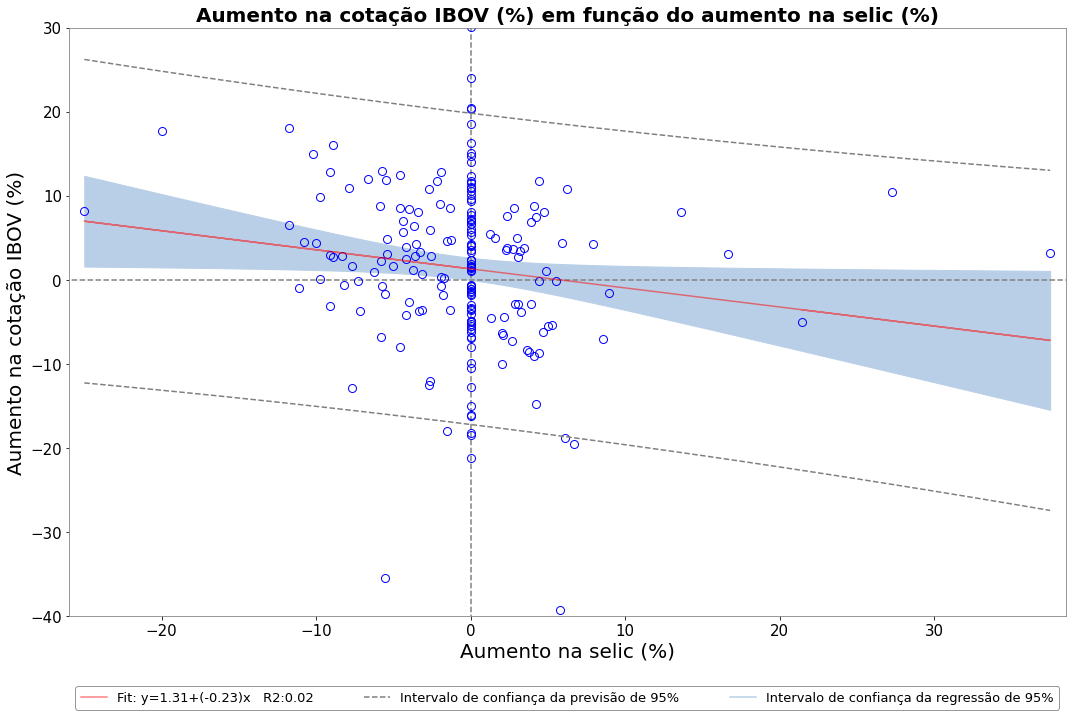

In [22]:
x,y=data_selic_mudanca['aumento_selic%'],data_selic_mudanca['aumento_cotacao%']
p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients
correlation = np.corrcoef(x, y)[0,1]
r2=correlation**2
# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error


# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 10))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="red", linewidth=1.5, alpha=0.5, label="Fit: y={:.2f}+({:.2f})x   R2:{:.2f}".format(p[1],p[0],r2))  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)

# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="Intervalo de confiança da previsão de 95%")
ax.plot(x2, y2 + pi, "--", color="0.5")


# Figure Modifications --------------------------------------------------------
# Borders
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out", labelsize=15)
ax.get_yaxis().set_tick_params(direction="out", labelsize=15)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left() 

# Labels
plt.title("Aumento na cotação IBOV (%) em função do aumento na selic (%)", fontsize="20", fontweight="bold")
plt.ylabel("Aumento na cotação IBOV (%)",fontsize=20)
plt.xlabel("Aumento na selic (%)",fontsize=20)
plt.xlim(np.min(x) - 1, np.max(x) + 1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["Intervalo de confiança da regressão de 95%"],
    loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand",fontsize=13
)  
frame = legend.get_frame().set_edgecolor("0.5")
ax.vlines(0,-100,100,color='grey',linestyles='dashed')
ax.hlines(0,-50,50,color='grey',linestyles='dashed')

# Save Figure
plt.ylim(-40,30)
plt.tight_layout()

Em seguida, comparou-se a variação percentual do Ibovespa em relação à variação absoluta da Selic. 

Essa variável explica 3% (R2=0.03) da variação do Ibovespa, sendo portanto mais explicativa das variações. Para um aumento de 1 ponto na Selic, espera-se uma queda média de 2.8% na cotação do Ibovespa.

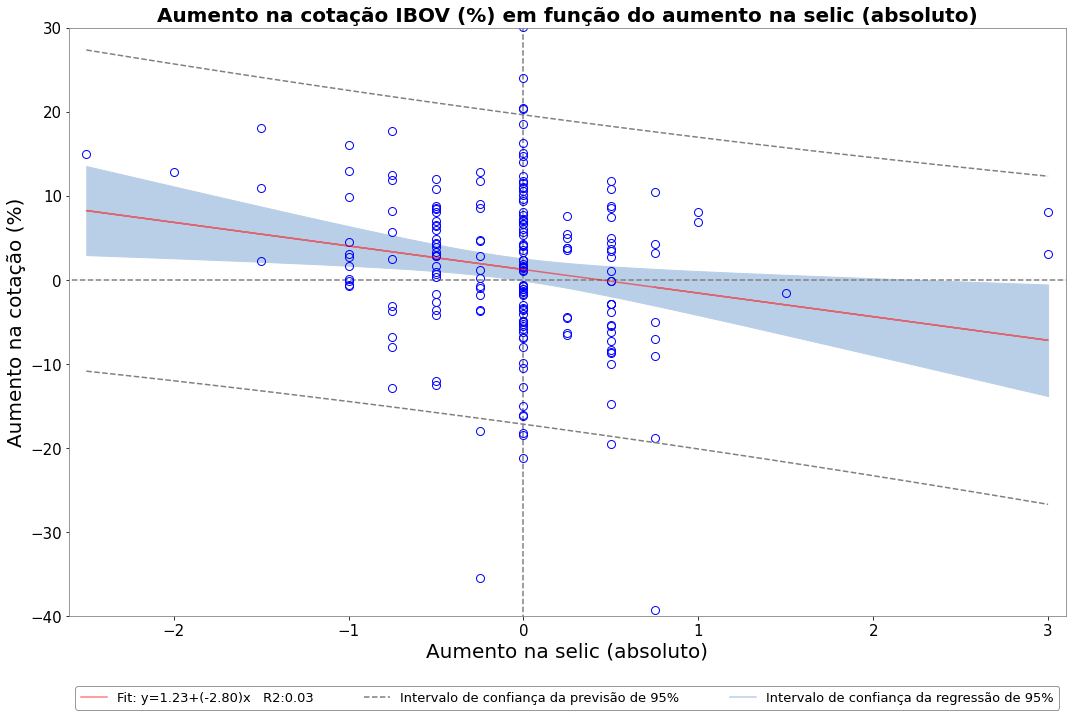

In [23]:
x,y=data_selic_mudanca['aumento_selic'],data_selic_mudanca['aumento_cotacao%']
p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients
correlation = np.corrcoef(x, y)[0,1]
r2=correlation**2
# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error


# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 10))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="red", linewidth=1.5, alpha=0.5, label="Fit: y={:.2f}+({:.2f})x   R2:{:.2f}".format(p[1],p[0],r2))  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)

# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="Intervalo de confiança da previsão de 95%")
ax.plot(x2, y2 + pi, "--", color="0.5")


# Figure Modifications --------------------------------------------------------
# Borders
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out", labelsize=15)
ax.get_yaxis().set_tick_params(direction="out", labelsize=15)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left() 

# Labels
plt.title("Aumento na cotação IBOV (%) em função do aumento na selic (absoluto)", fontsize="20", fontweight="bold")
plt.ylabel("Aumento na cotação (%)",fontsize=20)
plt.xlabel("Aumento na selic (absoluto)",fontsize=20)
plt.xlim(np.min(x) - 1, np.max(x) + 1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["Intervalo de confiança da regressão de 95%"],
    loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand",fontsize=13
)  
frame = legend.get_frame().set_edgecolor("0.5")
ax.vlines(0,-100,100,color='grey',linestyles='dashed')
ax.hlines(0,-50,50,color='grey',linestyles='dashed')

# Save Figure
plt.ylim(-40,30)
plt.xlim(-2.6,3.1)
plt.tight_layout()

Finalmente, foi estudada a relação entre o valor absoluto da Selic com a cotação da bolsa. Do gráfico abaixo é possível ver que não há relação entre ambos os valores. 

O fato de a selic estar em um determinado valor não influencia no comportamento da cotação. Pode-se pensar que isso se deve ao fato de o mercado já ter precificado a Selic nas ações. Em outras palavras, apenas mudanças na selic aparentam acarretar mudanças na cotação bolsa.

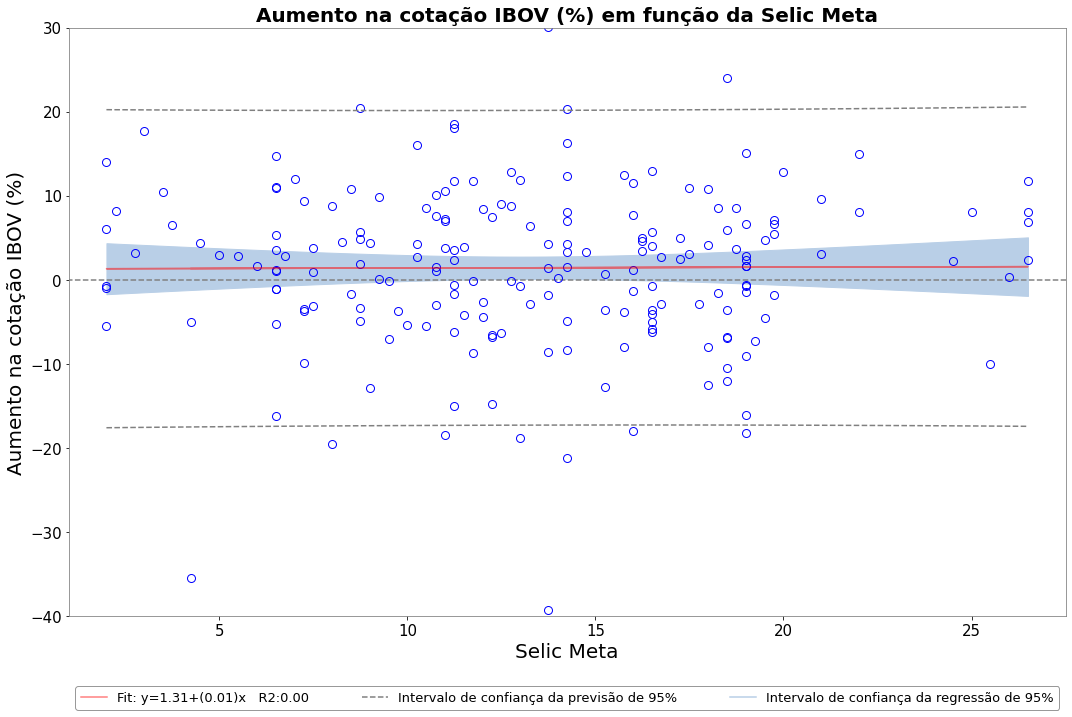

In [24]:
x,y=data_selic_mudanca['Selic Meta'],data_selic_mudanca['aumento_cotacao%']
p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients
correlation = np.corrcoef(x, y)[0,1]
r2=correlation**2
# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error


# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 10))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="red", linewidth=1.5, alpha=0.5, label="Fit: y={:.2f}+({:.2f})x   R2:{:.2f}".format(p[1],p[0],r2))  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)

# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="Intervalo de confiança da previsão de 95%")
ax.plot(x2, y2 + pi, "--", color="0.5")


# Figure Modifications --------------------------------------------------------
# Borders
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out", labelsize=15)
ax.get_yaxis().set_tick_params(direction="out", labelsize=15)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left() 

# Labels
plt.title("Aumento na cotação IBOV (%) em função da Selic Meta", fontsize="20", fontweight="bold")
plt.ylabel("Aumento na cotação IBOV (%)",fontsize=20)
plt.xlabel("Selic Meta",fontsize=20)
plt.xlim(np.min(x) - 1, np.max(x) + 1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["Intervalo de confiança da regressão de 95%"],
    loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand",fontsize=13
)  
frame = legend.get_frame().set_edgecolor("0.5")
ax.vlines(0,-100,100,color='grey',linestyles='dashed')
ax.hlines(0,-50,50,color='grey',linestyles='dashed')

# Save Figure
plt.ylim(-40,30)
plt.tight_layout()

## 5. Próximos passos

Pretendo atualizar essa análise estudando outras variáveis que possam impactar na cotação. Entre elas:

1. Inflação
2. Índice de confiança do consumidor.
3. Índices de commodities.
4. Cotação da bolsa americana e bolsa chinesa.